In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os,sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from pathlib import Path
import json 

from io import StringIO
import pprint

import logging
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.INFO)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.INFO)

import seaborn as sns
sns.set(rc={'figure.figsize':(24,4)})

sns.set_style("whitegrid")
sns.set_context("talk")

#Python files
from config import Configuration 

from utils import *
from models_helper import *
from datasets import EclipseSampledDataset, VoltaSampledDataset, ODDSDataset
from models import BaseAutoencoder
# from models import DNN_AE
# from models import Supervised_SAE


2.3.0


In [75]:
###SKLEARN
from sklearn.model_selection import train_test_split   

###TENSORFLOW
import tensorflow as tf
seed = 39
tf.compat.v1.set_random_seed(
    seed
)

print(tf.__version__)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import layers,losses

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Flatten
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Input, ZeroPadding2D, ZeroPadding1D
from tensorflow.keras.layers import GlobalAveragePooling1D, BatchNormalization, UpSampling1D

#Convolution
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, UpSampling1D, UpSampling2D


from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.losses import CategoricalCrossentropy

2.3.0


In [76]:
class Autoencoder(Model):
    def __init__(self, params):
        super(Autoencoder, self).__init__()
        self.params = params
        
        self.encoder = tf.keras.Sequential([
          #layers.Dropout(params['dropout']),                        
          #layers.Dense(1000, activation=params['hidden_acts']),
          layers.Dense(params['latent_dim'], activation=params['latent_activation'],name='code')
        ],name='Encoder')
        
        self.decoder = tf.keras.Sequential([
          #layers.Dense(1000, activation=params['hidden_acts']),                        
          #layers.Dropout(params['dropout']),                        
          layers.Dense(x_dim, activation='linear'),            
        ],name='Decoder')

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def get_config(self):
        return {
            "model_name": self.params['model_name'],
            #Layer related stuff
            "latent_dim": self.params['latent_dim'],
            "latent_activation": self.params['latent_activation'],
            "dropout_rate": self.params['dropout'],
            "regularizer": self.params['regularizer'],            
            "regularization_rate": self.params['regularization_rate'],                        
            #Compilation related stuff            
            "optimizer": self.optimizer,
            "loss": self.loss,
            #Training
            "epochs": self.params['epochs']
        }    

In [78]:
# burhack = tf.keras.models.load_model('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/tuncer_baseline_10/CV_0/AE_5/model/dae')
# burhack.get_config()

In [79]:
SCALER = 'MinMax'
EXP_NAME = 'anomaly_diagnosis_CR_Seed'

MODEL_NAME = 'AE_CR' #Name of the dir that has trained AE
SYSTEM = 'eclipse'
FEATURE_SELECTION = False

In [80]:
params = {}

#Compile related
params['model_name'] = 'dae'
params['loss'] = 'mse'

params['optimizer'] = 'adadelta'
params['learning_rate'] = 1e-3

#Layer related
params['dropout'] = 0 #This will add dropout after layers
params['regularizer'] = None
params['regularization_rate'] = None

params['hidden_layers'] = []
params['hidden_acts'] = 'relu'

params['latent_dim'] =  2000 
params['latent_activation'] = 'relu' #change the activation of the code layer


#Training related
params['epochs'] = 250


if params['optimizer'] == 'adam':
    opt = optimizers.Adam(learning_rate=params['learning_rate'])
elif params['optimizer'] == 'adadelta':
    opt = optimizers.Adadelta(learning_rate=params['learning_rate'])
elif params['optimizer'] == 'sgd':
    opt = optimizers.SGD(learning_rate=params['learning_rate'])


if params['loss'] == 'mse':
    selected_loss = losses.MeanSquaredError()
elif params['loss'] == 'mae':
    selected_loss = losses.MeanAbsoluteError()
        

2021-03-23 08:02:38,117 INFO    Setting directory names
2021-03-23 08:02:38,118 INFO    Model config folder already exists, be careful, otherwise it will overwrite!
2021-03-23 08:02:38,119 INFO    Saving configuration
2021-03-23 08:02:38,122 INFO    BaseDataset Class Initialization
2021-03-23 08:02:38,123 INFO    HPCDataset Class Initialization
2021-03-23 08:02:38,123 INFO    EclipseSampledDataset Class Initialization


# The configuration used for this run:
# {'cv_fold': 0,
#  'exp_name': 'anomaly_diagnosis_CR_Seed',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/eclipse_sampled_hdfs'),
#  'metadata_path': None,
#  'model_config': 'AE_CR',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_0/AE_CR'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_0/AE_CR/model'),
#  'num_split': 5,
#  'operation': 'label_generate',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_0/AE_CR/model/plots'),
#  'processed_l

2021-03-23 08:02:38,464 INFO    Train data shape (673, 1716)
2021-03-23 08:02:38,465 INFO    Train label shape (673, 2)
2021-03-23 08:02:38,465 INFO    Test data shape (3140, 1716)
2021-03-23 08:02:38,465 INFO    Test label shape (3140, 2)
2021-03-23 08:02:38,565 INFO    Train data shape (673, 1716)
2021-03-23 08:02:38,566 INFO    Train label shape (673, 2)
2021-03-23 08:02:38,566 INFO    Test data shape (3140, 1716)
2021-03-23 08:02:38,567 INFO    Test label shape (3140, 2)
2021-03-23 08:02:38,568 INFO    Train data label dist: 
0    607
2     17
1     17
4     16
3     16
Name: anom, dtype: int64
2021-03-23 08:02:38,571 INFO    Test data label dist: 
0    913
1    559
2    559
3    556
4    553
Name: anom, dtype: int64
2021-03-23 08:02:38,672 WARNING AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x2b83ebeeb1e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `expor

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
code (Dense)                 (673, 2000)               3434000   
Total params: 3,434,000
Trainable params: 3,434,000
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (673, 1716)               3433716   
Total params: 3,433,716
Trainable params: 3,433,716
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

2021-03-23 08:02:38,679 WARNING AutoGraph could not transform <bound method Autoencoder.call of <__main__.Autoencoder object at 0x2b82686c7cf8>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
14/17 [=======================>......] - ETA: 0s - loss: 0.1206

2021-03-23 08:02:39,112 WARNING AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b8268dd37b8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 0s 19ms/step - loss: 0.1208 - val_loss: 0.1174
Epoch 2/250
17/17 [==============================] - 0s 16ms/step - loss: 0.1202 - val_loss: 0.1170
Epoch 3/250
17/17 [==============================] - 0s 12ms/step - loss: 0.1195 - val_loss: 0.1165
Epoch 4/250
17/17 [==============================] - 0s 13ms/step - loss: 0.1189 - val_loss: 0.1161
Epoch 5/250
17/17 [==============================] - 0s 14ms/step - loss: 0.1183 - val_loss: 0.1156
Epoch 6/250
17/17 [==============================] - 0s 14ms/step - loss: 0.1177 - val_loss: 0.1152
Epoch 7/250
17/17 [==============================] - 0s 15ms/step - loss: 0.1172 - val_loss: 0.1148
E

Epoch 78/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0873 - val_loss: 0.0926
Epoch 79/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0870 - val_loss: 0.0923
Epoch 80/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0867 - val_loss: 0.0921
Epoch 81/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0864 - val_loss: 0.0919
Epoch 82/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0861 - val_loss: 0.0917
Epoch 83/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0858 - val_loss: 0.0915
Epoch 84/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0855 - val_loss: 0.0913
Epoch 85/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0852 - val_loss: 0.0910
Epoch 86/250
17/17 [==============================] - 0s 16ms/step - loss: 0.0850 - val_loss: 0.0908
Epoch 87/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0847 - val_los

17/17 [==============================] - 0s 14ms/step - loss: 0.0689 - val_loss: 0.0787
Epoch 159/250
17/17 [==============================] - 0s 11ms/step - loss: 0.0687 - val_loss: 0.0786
Epoch 160/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0685 - val_loss: 0.0784
Epoch 161/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0684 - val_loss: 0.0783
Epoch 162/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0682 - val_loss: 0.0782
Epoch 163/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0680 - val_loss: 0.0780
Epoch 164/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0678 - val_loss: 0.0779
Epoch 165/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0677 - val_loss: 0.0778
Epoch 166/250
17/17 [==============================] - 0s 16ms/step - loss: 0.0675 - val_loss: 0.0776
Epoch 167/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0673 - val_loss: 0

17/17 [==============================] - 0s 16ms/step - loss: 0.0569 - val_loss: 0.0695
Epoch 239/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0567 - val_loss: 0.0694
Epoch 240/250
17/17 [==============================] - 0s 17ms/step - loss: 0.0566 - val_loss: 0.0693
Epoch 241/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0565 - val_loss: 0.0692
Epoch 242/250
17/17 [==============================] - 0s 16ms/step - loss: 0.0564 - val_loss: 0.0691
Epoch 243/250
17/17 [==============================] - 0s 17ms/step - loss: 0.0562 - val_loss: 0.0690
Epoch 244/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0561 - val_loss: 0.0689
Epoch 245/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0560 - val_loss: 0.0688
Epoch 246/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0559 - val_loss: 0.0687
Epoch 247/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0557 - val_loss: 0

2021-03-23 08:03:43,271 WARNING AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x2b83fc0fd268> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-03-23 08:03:44,024 INFO    Assets written to: /projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_0/AE_CR/model/dae/assets
2021-03-23 08:03:44,040 INFO    Model saved!
2021-03-23 08:03:44,044 INFO    Setting directory names
2021-03-23 08:03:44,045 INFO    Model config folder already exists, be careful, otherwise it will overwrite!
2021-03-23 08:03:44,046 INFO    Saving configuration
2021-03-23 08:03:44,049 INFO    BaseDataset Class Initialization
2021-03-23 08:03:44,049 INFO    HPCDataset Class Initialization
2021-03-23 08:03:44,049 INFO    EclipseSampledDataset Class Initialization


# The configuration used for this run:
# {'cv_fold': 1,
#  'exp_name': 'anomaly_diagnosis_CR_Seed',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/eclipse_sampled_hdfs'),
#  'metadata_path': None,
#  'model_config': 'AE_CR',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_1/AE_CR'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_1/AE_CR/model'),
#  'num_split': 5,
#  'operation': 'label_generate',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_1/AE_CR/model/plots'),
#  'processed_l

2021-03-23 08:03:44,569 INFO    Train data shape (673, 1716)
2021-03-23 08:03:44,570 INFO    Train label shape (673, 2)
2021-03-23 08:03:44,571 INFO    Test data shape (3140, 1716)
2021-03-23 08:03:44,571 INFO    Test label shape (3140, 2)
2021-03-23 08:03:44,647 INFO    Train data shape (673, 1716)
2021-03-23 08:03:44,648 INFO    Train label shape (673, 2)
2021-03-23 08:03:44,648 INFO    Test data shape (3140, 1716)
2021-03-23 08:03:44,648 INFO    Test label shape (3140, 2)
2021-03-23 08:03:44,650 INFO    Train data label dist: 
0    607
2     17
1     17
4     16
3     16
Name: anom, dtype: int64
2021-03-23 08:03:44,651 INFO    Test data label dist: 
0    913
1    559
2    559
3    556
4    553
Name: anom, dtype: int64
2021-03-23 08:03:44,743 WARNING AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x2b83fea6c158> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `expor

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
code (Dense)                 (673, 2000)               3434000   
Total params: 3,434,000
Trainable params: 3,434,000
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (673, 1716)               3433716   
Total params: 3,433,716
Trainable params: 3,433,716
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

2021-03-23 08:03:45,140 WARNING AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b83fea32b70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 0s 17ms/step - loss: 0.1203 - val_loss: 0.1189
Epoch 2/250
17/17 [==============================] - 0s 11ms/step - loss: 0.1197 - val_loss: 0.1184
Epoch 3/250
17/17 [==============================] - 0s 15ms/step - loss: 0.1191 - val_loss: 0.1180
Epoch 4/250
17/17 [==============================] - 0s 11ms/step - loss: 0.1186 - val_loss: 0.1176
Epoch 5/250
17/17 [==============================] - 0s 14ms/step - loss: 0.1180 - val_loss: 0.1171
Epoch 6/250
17/17 [==============================] - 0s 13ms/step - loss: 0.1174 - val_loss: 0.1167
Epoch 7/250
17/17 [==============================] - 0s 12ms/step - loss: 0.1169 - val_loss: 0.1163
E

Epoch 78/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0883 - val_loss: 0.0946
Epoch 79/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0880 - val_loss: 0.0944
Epoch 80/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0877 - val_loss: 0.0942
Epoch 81/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0874 - val_loss: 0.0940
Epoch 82/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0871 - val_loss: 0.0938
Epoch 83/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0869 - val_loss: 0.0935
Epoch 84/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0866 - val_loss: 0.0933
Epoch 85/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0863 - val_loss: 0.0931
Epoch 86/250
17/17 [==============================] - 0s 11ms/step - loss: 0.0860 - val_loss: 0.0929
Epoch 87/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0858 - val_los

17/17 [==============================] - 0s 12ms/step - loss: 0.0704 - val_loss: 0.0808
Epoch 159/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0702 - val_loss: 0.0807
Epoch 160/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0700 - val_loss: 0.0806
Epoch 161/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0699 - val_loss: 0.0804
Epoch 162/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0697 - val_loss: 0.0803
Epoch 163/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0695 - val_loss: 0.0802
Epoch 164/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0694 - val_loss: 0.0800
Epoch 165/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0692 - val_loss: 0.0799
Epoch 166/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0690 - val_loss: 0.0798
Epoch 167/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0689 - val_loss: 0

17/17 [==============================] - 0s 12ms/step - loss: 0.0586 - val_loss: 0.0716
Epoch 239/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0584 - val_loss: 0.0715
Epoch 240/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0583 - val_loss: 0.0714
Epoch 241/250
17/17 [==============================] - 0s 11ms/step - loss: 0.0582 - val_loss: 0.0713
Epoch 242/250
17/17 [==============================] - 0s 16ms/step - loss: 0.0581 - val_loss: 0.0712
Epoch 243/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0579 - val_loss: 0.0711
Epoch 244/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0578 - val_loss: 0.0710
Epoch 245/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0577 - val_loss: 0.0709
Epoch 246/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0576 - val_loss: 0.0708
Epoch 247/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0574 - val_loss: 0

2021-03-23 08:04:43,790 WARNING AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x2b82690ff048> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-03-23 08:04:44,284 INFO    Assets written to: /projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_1/AE_CR/model/dae/assets
2021-03-23 08:04:44,300 INFO    Model saved!
2021-03-23 08:04:44,303 INFO    Setting directory names
2021-03-23 08:04:44,307 INFO    Saving configuration
2021-03-23 08:04:44,310 INFO    BaseDataset Class Initialization
2021-03-23 08:04:44,310 INFO    HPCDataset Class Initialization
2021-03-23 08:04:44,310 INFO    EclipseSampledDataset Class Initialization


# The configuration used for this run:
# {'cv_fold': 2,
#  'exp_name': 'anomaly_diagnosis_CR_Seed',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/eclipse_sampled_hdfs'),
#  'metadata_path': None,
#  'model_config': 'AE_CR',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_2/AE_CR'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_2/AE_CR/model'),
#  'num_split': 5,
#  'operation': 'label_generate',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_2/AE_CR/model/plots'),
#  'processed_l

2021-03-23 08:04:44,760 INFO    Train data shape (673, 1716)
2021-03-23 08:04:44,761 INFO    Train label shape (673, 2)
2021-03-23 08:04:44,762 INFO    Test data shape (3140, 1716)
2021-03-23 08:04:44,762 INFO    Test label shape (3140, 2)
2021-03-23 08:04:44,830 INFO    Train data shape (673, 1716)
2021-03-23 08:04:44,830 INFO    Train label shape (673, 2)
2021-03-23 08:04:44,831 INFO    Test data shape (3140, 1716)
2021-03-23 08:04:44,831 INFO    Test label shape (3140, 2)
2021-03-23 08:04:44,833 INFO    Train data label dist: 
0    607
2     17
1     17
4     16
3     16
Name: anom, dtype: int64
2021-03-23 08:04:44,835 INFO    Test data label dist: 
0    913
1    559
2    559
3    556
4    553
Name: anom, dtype: int64
2021-03-23 08:04:44,935 WARNING AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x2b8273edd950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `expor

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
code (Dense)                 (673, 2000)               3434000   
Total params: 3,434,000
Trainable params: 3,434,000
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (673, 1716)               3433716   
Total params: 3,433,716
Trainable params: 3,433,716
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

2021-03-23 08:04:45,396 WARNING AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b82689e5378> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 0s 20ms/step - loss: 0.1268 - val_loss: 0.1256
Epoch 2/250
17/17 [==============================] - 0s 13ms/step - loss: 0.1261 - val_loss: 0.1251
Epoch 3/250
17/17 [==============================] - 0s 14ms/step - loss: 0.1254 - val_loss: 0.1245
Epoch 4/250
17/17 [==============================] - 0s 11ms/step - loss: 0.1247 - val_loss: 0.1240
Epoch 5/250
17/17 [==============================] - 0s 13ms/step - loss: 0.1240 - val_loss: 0.1235
Epoch 6/250
17/17 [==============================] - 0s 14ms/step - loss: 0.1234 - val_loss: 0.1230
Epoch 7/250
17/17 [==============================] - 0s 16ms/step - loss: 0.1227 - val_loss: 0.1225
E

Epoch 78/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0901 - val_loss: 0.0974
Epoch 79/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0898 - val_loss: 0.0971
Epoch 80/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0895 - val_loss: 0.0969
Epoch 81/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0891 - val_loss: 0.0967
Epoch 82/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0888 - val_loss: 0.0964
Epoch 83/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0885 - val_loss: 0.0962
Epoch 84/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0882 - val_loss: 0.0959
Epoch 85/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0879 - val_loss: 0.0957
Epoch 86/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0876 - val_loss: 0.0955
Epoch 87/250
17/17 [==============================] - 0s 16ms/step - loss: 0.0873 - val_los

17/17 [==============================] - 0s 15ms/step - loss: 0.0708 - val_loss: 0.0822
Epoch 159/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0706 - val_loss: 0.0820
Epoch 160/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0704 - val_loss: 0.0819
Epoch 161/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0702 - val_loss: 0.0818
Epoch 162/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0701 - val_loss: 0.0816
Epoch 163/250
17/17 [==============================] - 0s 16ms/step - loss: 0.0699 - val_loss: 0.0815
Epoch 164/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0697 - val_loss: 0.0813
Epoch 165/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0695 - val_loss: 0.0812
Epoch 166/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0693 - val_loss: 0.0810
Epoch 167/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0692 - val_loss: 0

17/17 [==============================] - 0s 12ms/step - loss: 0.0584 - val_loss: 0.0723
Epoch 239/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0583 - val_loss: 0.0722
Epoch 240/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0582 - val_loss: 0.0721
Epoch 241/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0581 - val_loss: 0.0720
Epoch 242/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0579 - val_loss: 0.0719
Epoch 243/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0578 - val_loss: 0.0718
Epoch 244/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0577 - val_loss: 0.0717
Epoch 245/250
17/17 [==============================] - 0s 16ms/step - loss: 0.0575 - val_loss: 0.0716
Epoch 246/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0574 - val_loss: 0.0715
Epoch 247/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0573 - val_loss: 0

2021-03-23 08:05:48,056 WARNING AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x2b82676b6ea0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-03-23 08:05:48,549 INFO    Assets written to: /projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_2/AE_CR/model/dae/assets
2021-03-23 08:05:48,563 INFO    Model saved!
2021-03-23 08:05:48,566 INFO    Setting directory names
2021-03-23 08:05:48,571 INFO    Saving configuration
2021-03-23 08:05:48,573 INFO    BaseDataset Class Initialization
2021-03-23 08:05:48,574 INFO    HPCDataset Class Initialization
2021-03-23 08:05:48,574 INFO    EclipseSampledDataset Class Initialization


# The configuration used for this run:
# {'cv_fold': 3,
#  'exp_name': 'anomaly_diagnosis_CR_Seed',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/eclipse_sampled_hdfs'),
#  'metadata_path': None,
#  'model_config': 'AE_CR',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_3/AE_CR'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_3/AE_CR/model'),
#  'num_split': 5,
#  'operation': 'label_generate',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_3/AE_CR/model/plots'),
#  'processed_l

2021-03-23 08:05:49,107 INFO    Train data shape (673, 1716)
2021-03-23 08:05:49,108 INFO    Train label shape (673, 2)
2021-03-23 08:05:49,108 INFO    Test data shape (3140, 1716)
2021-03-23 08:05:49,108 INFO    Test label shape (3140, 2)
2021-03-23 08:05:49,202 INFO    Train data shape (673, 1716)
2021-03-23 08:05:49,203 INFO    Train label shape (673, 2)
2021-03-23 08:05:49,203 INFO    Test data shape (3140, 1716)
2021-03-23 08:05:49,203 INFO    Test label shape (3140, 2)
2021-03-23 08:05:49,205 INFO    Train data label dist: 
0    607
2     17
1     17
4     16
3     16
Name: anom, dtype: int64
2021-03-23 08:05:49,207 INFO    Test data label dist: 
0    913
1    559
2    559
3    556
4    553
Name: anom, dtype: int64
2021-03-23 08:05:49,304 WARNING AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x2b83eba74400> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `expor

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
code (Dense)                 (673, 2000)               3434000   
Total params: 3,434,000
Trainable params: 3,434,000
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (673, 1716)               3433716   
Total params: 3,433,716
Trainable params: 3,433,716
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

2021-03-23 08:05:49,721 WARNING AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b83fea9e268> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 0s 17ms/step - loss: 0.1222 - val_loss: 0.1200
Epoch 2/250
17/17 [==============================] - 0s 13ms/step - loss: 0.1216 - val_loss: 0.1196
Epoch 3/250
17/17 [==============================] - 0s 12ms/step - loss: 0.1210 - val_loss: 0.1191
Epoch 4/250
17/17 [==============================] - 0s 12ms/step - loss: 0.1204 - val_loss: 0.1187
Epoch 5/250
17/17 [==============================] - 0s 11ms/step - loss: 0.1198 - val_loss: 0.1182
Epoch 6/250
17/17 [==============================] - 0s 14ms/step - loss: 0.1192 - val_loss: 0.1178
Epoch 7/250
17/17 [==============================] - 0s 14ms/step - loss: 0.1186 - val_loss: 0.1173
E

Epoch 78/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0885 - val_loss: 0.0949
Epoch 79/250
17/17 [==============================] - 0s 16ms/step - loss: 0.0882 - val_loss: 0.0947
Epoch 80/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0879 - val_loss: 0.0945
Epoch 81/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0876 - val_loss: 0.0943
Epoch 82/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0873 - val_loss: 0.0941
Epoch 83/250
17/17 [==============================] - 0s 16ms/step - loss: 0.0870 - val_loss: 0.0938
Epoch 84/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0867 - val_loss: 0.0936
Epoch 85/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0864 - val_loss: 0.0934
Epoch 86/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0862 - val_loss: 0.0932
Epoch 87/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0859 - val_los

17/17 [==============================] - 0s 14ms/step - loss: 0.0701 - val_loss: 0.0810
Epoch 159/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0699 - val_loss: 0.0809
Epoch 160/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0697 - val_loss: 0.0807
Epoch 161/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0695 - val_loss: 0.0806
Epoch 162/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0694 - val_loss: 0.0804
Epoch 163/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0692 - val_loss: 0.0803
Epoch 164/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0690 - val_loss: 0.0802
Epoch 165/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0688 - val_loss: 0.0800
Epoch 166/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0687 - val_loss: 0.0799
Epoch 167/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0685 - val_loss: 0

17/17 [==============================] - 0s 13ms/step - loss: 0.0582 - val_loss: 0.0718
Epoch 239/250
17/17 [==============================] - 0s 11ms/step - loss: 0.0580 - val_loss: 0.0717
Epoch 240/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0579 - val_loss: 0.0716
Epoch 241/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0578 - val_loss: 0.0715
Epoch 242/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0577 - val_loss: 0.0714
Epoch 243/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0575 - val_loss: 0.0713
Epoch 244/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0574 - val_loss: 0.0712
Epoch 245/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0573 - val_loss: 0.0711
Epoch 246/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0572 - val_loss: 0.0710
Epoch 247/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0570 - val_loss: 0

2021-03-23 08:06:48,749 WARNING AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x2b8265eaf7b8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-03-23 08:06:49,224 INFO    Assets written to: /projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_3/AE_CR/model/dae/assets
2021-03-23 08:06:49,238 INFO    Model saved!
2021-03-23 08:06:49,241 INFO    Setting directory names
2021-03-23 08:06:49,245 INFO    Saving configuration
2021-03-23 08:06:49,248 INFO    BaseDataset Class Initialization
2021-03-23 08:06:49,248 INFO    HPCDataset Class Initialization
2021-03-23 08:06:49,249 INFO    EclipseSampledDataset Class Initialization


# The configuration used for this run:
# {'cv_fold': 4,
#  'exp_name': 'anomaly_diagnosis_CR_Seed',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/eclipse_sampled_hdfs'),
#  'metadata_path': None,
#  'model_config': 'AE_CR',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_4/AE_CR'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_4/AE_CR/model'),
#  'num_split': 5,
#  'operation': 'label_generate',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_4/AE_CR/model/plots'),
#  'processed_l

2021-03-23 08:06:49,754 INFO    Train data shape (673, 1716)
2021-03-23 08:06:49,755 INFO    Train label shape (673, 2)
2021-03-23 08:06:49,755 INFO    Test data shape (3140, 1716)
2021-03-23 08:06:49,756 INFO    Test label shape (3140, 2)
2021-03-23 08:06:49,827 INFO    Train data shape (673, 1716)
2021-03-23 08:06:49,827 INFO    Train label shape (673, 2)
2021-03-23 08:06:49,828 INFO    Test data shape (3140, 1716)
2021-03-23 08:06:49,828 INFO    Test label shape (3140, 2)
2021-03-23 08:06:49,830 INFO    Train data label dist: 
0    607
2     17
1     17
4     16
3     16
Name: anom, dtype: int64
2021-03-23 08:06:49,832 INFO    Test data label dist: 
0    913
1    559
2    559
3    556
4    553
Name: anom, dtype: int64
2021-03-23 08:06:49,923 WARNING AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x2b826891f598> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `expor

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
code (Dense)                 (673, 2000)               3434000   
Total params: 3,434,000
Trainable params: 3,434,000
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (673, 1716)               3433716   
Total params: 3,433,716
Trainable params: 3,433,716
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

2021-03-23 08:06:50,278 WARNING AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b8268560ea0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 0s 14ms/step - loss: 0.1234 - val_loss: 0.1191
Epoch 2/250
17/17 [==============================] - 0s 12ms/step - loss: 0.1227 - val_loss: 0.1187
Epoch 3/250
17/17 [==============================] - 0s 11ms/step - loss: 0.1221 - val_loss: 0.1182
Epoch 4/250
17/17 [==============================] - 0s 11ms/step - loss: 0.1215 - val_loss: 0.1177
Epoch 5/250
17/17 [==============================] - 0s 12ms/step - loss: 0.1209 - val_loss: 0.1173
Epoch 6/250
17/17 [==============================] - 0s 13ms/step - loss: 0.1202 - val_loss: 0.1168
Epoch 7/250
17/17 [==============================] - 0s 10ms/step - loss: 0.1196 - val_loss: 0.1164
E

Epoch 78/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0888 - val_loss: 0.0935
Epoch 79/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0885 - val_loss: 0.0933
Epoch 80/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0882 - val_loss: 0.0930
Epoch 81/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0879 - val_loss: 0.0928
Epoch 82/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0876 - val_loss: 0.0926
Epoch 83/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0873 - val_loss: 0.0924
Epoch 84/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0870 - val_loss: 0.0922
Epoch 85/250
17/17 [==============================] - 0s 11ms/step - loss: 0.0867 - val_loss: 0.0919
Epoch 86/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0864 - val_loss: 0.0917
Epoch 87/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0862 - val_los

17/17 [==============================] - 0s 12ms/step - loss: 0.0701 - val_loss: 0.0794
Epoch 159/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0700 - val_loss: 0.0792
Epoch 160/250
17/17 [==============================] - 0s 11ms/step - loss: 0.0698 - val_loss: 0.0791
Epoch 161/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0696 - val_loss: 0.0790
Epoch 162/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0694 - val_loss: 0.0788
Epoch 163/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0693 - val_loss: 0.0787
Epoch 164/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0691 - val_loss: 0.0786
Epoch 165/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0689 - val_loss: 0.0784
Epoch 166/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0687 - val_loss: 0.0783
Epoch 167/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0686 - val_loss: 0

17/17 [==============================] - 0s 12ms/step - loss: 0.0581 - val_loss: 0.0701
Epoch 239/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0579 - val_loss: 0.0700
Epoch 240/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0578 - val_loss: 0.0699
Epoch 241/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0577 - val_loss: 0.0698
Epoch 242/250
17/17 [==============================] - 0s 12ms/step - loss: 0.0575 - val_loss: 0.0697
Epoch 243/250
17/17 [==============================] - 0s 11ms/step - loss: 0.0574 - val_loss: 0.0696
Epoch 244/250
17/17 [==============================] - 0s 14ms/step - loss: 0.0573 - val_loss: 0.0695
Epoch 245/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0572 - val_loss: 0.0694
Epoch 246/250
17/17 [==============================] - 0s 15ms/step - loss: 0.0570 - val_loss: 0.0693
Epoch 247/250
17/17 [==============================] - 0s 13ms/step - loss: 0.0569 - val_loss: 0

2021-03-23 08:07:47,796 WARNING AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x2b8267ecfd08> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-03-23 08:07:48,293 INFO    Assets written to: /projectnb/peaclab-mon/aksar/adaptability_experiments/eclipse/anomaly_diagnosis_CR_Seed/CV_4/AE_CR/model/dae/assets
2021-03-23 08:07:48,308 INFO    Model saved!


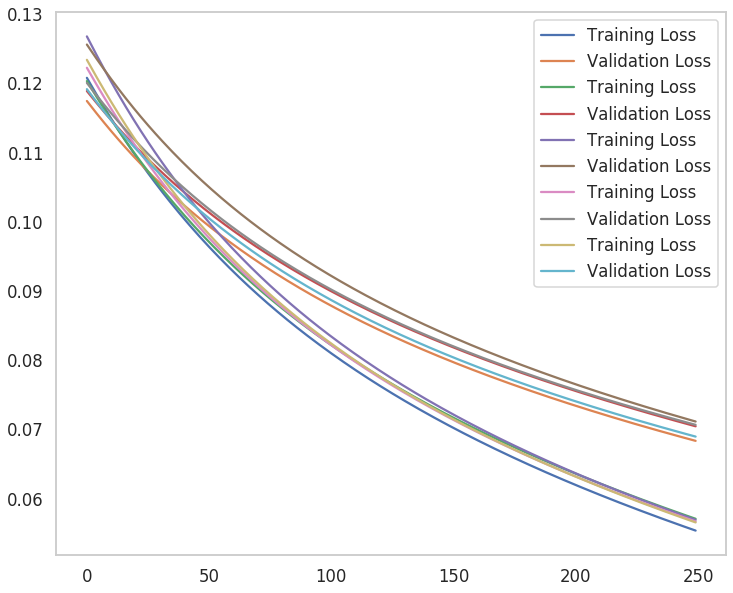

In [81]:
#for CV_INDEX in [0,1,2,3,4]:
for CV_INDEX in [0,1,2,3,4]:    

    conf = Configuration(ipython=True,
                         overrides={
                             'model_config': MODEL_NAME,
                             'cv_fold':CV_INDEX, #States which CV folder should be read 
                             'exp_name':EXP_NAME,                         
                             'system' : SYSTEM,
                             'num_split': 5,
                         })

    if SYSTEM == 'eclipse':

        import json
        with open(str(conf['experiment_dir']) + '/anom_dict.json') as f:
            ANOM_DICT = json.load(f)    

        eclipseDataset = EclipseSampledDataset(conf)
        train_data, train_label, test_data, test_label = eclipseDataset.load_dataset(scaler=SCALER,borghesi=False)
        assert list(train_data.index) == list(train_label.index) #check the order of the labels     
        assert list(test_data.index) == list(test_label.index) #check the order of the labels    

    elif SYSTEM == 'volta':

        import json
        with open(str(conf['experiment_dir']) + '/anom_dict.json') as f:
            ANOM_DICT = json.load(f)    

        voltaDataset = VoltaSampledDataset(conf)
        train_data, train_label, test_data, test_label = voltaDataset.load_dataset(scaler=SCALER)
        assert list(train_data.index) == list(train_label.index) #check the order of the labels     
        assert list(test_data.index) == list(test_label.index) #check the order of the labels           


    elif SYSTEM in ['thyroid','shuttle','satimage-2','satellite','cardio','arrhythmia']:

        dataset = ODDSDataset(root='/projectnb/peaclab-mon/aksar/nonhpc_datasets/ODDS',dataset_name=DATASET)
        train_data, train_label, test_data, test_label = dataset.load_dataset()

        logging.info("Train data shape %s",train_data.shape)
        logging.info("Train label shape %s",train_label.shape)
        logging.info("Test data shape %s",test_data.shape)  
        logging.info("Test label shape %s",test_label.shape)  
        
        
    if FEATURE_SELECTION:
        selected_features = pd.read_csv(exp_config['experiment_dir'] / 'selected_features.csv')
        #Training data with feature selection
        train_data = train_data[list(selected_features['0'].values)]
        test_data = test_data[list(selected_features['0'].values)]
        
    logging.info("Train data shape %s",train_data.shape)
    logging.info("Train label shape %s",train_label.shape)
    logging.info("Test data shape %s",test_data.shape)  
    logging.info("Test label shape %s",test_label.shape)

    logging.info("Train data label dist: \n%s",train_label['anom'].value_counts())
    logging.info("Test data label dist: \n%s",test_label['anom'].value_counts())         
        
        
    #BUILD AE
    
    TRAIN_DATA = train_data.values
    
    x_dim = TRAIN_DATA.shape[1]
    
    autoencoder = Autoencoder(params)       
        
    autoencoder.compile(optimizer=opt, loss=selected_loss)
    autoencoder.build(TRAIN_DATA.shape) 
    autoencoder.encoder.summary()
    autoencoder.decoder.summary()
    autoencoder.get_config()    
    
    es = EarlyStopping(monitor='val_loss', 
                                        verbose=1,
                                        patience=10,
                                        mode='min',
                                        restore_best_weights=True)

    history = autoencoder.fit(train_data.values, train_data.values,
                    epochs=params['epochs'],
                    shuffle=True,
                    callbacks =[
                                  es  
                                ],
                    validation_split = 0.2,
                    )

    plt.plot(history.history["loss"], label="Training Loss")
    if not history.history["val_loss"] is None:
        plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show

    autoencoder.save(str(conf['model_dir'] / (params['model_name'])))
    logging.info("Model saved!")    


   Average_MSE      Class
0     0.058457       None
1     0.064005  cachecopy
2     0.063934  cpuoccupy
3     0.062819      membw
4     0.064099    memleak
    Average_MSE      Class
0  8.111712e-02       None
1  8.774098e+00  cachecopy
2  7.890212e+00  cpuoccupy
3  3.007180e+02      membw
4  1.264700e+12    memleak


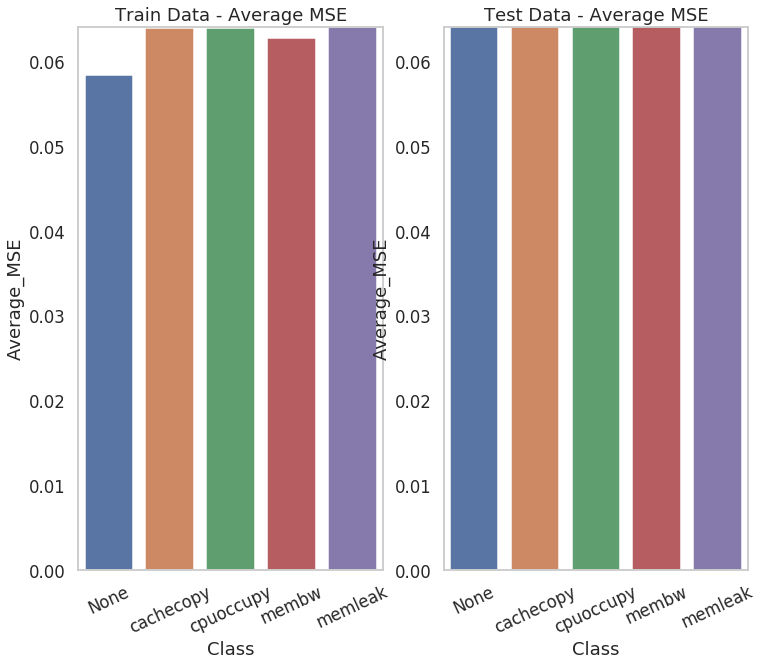

In [83]:
#Check overfitting

fig, axs = plt.subplots(1, 2)

mse_df = calc_MSE_class(autoencoder,train_data.values,train_label['anom'].values,ANOM_DICT)
sns.barplot(x="Class",y="Average_MSE",data=mse_df,ax=axs[0])
axs[0].set_title("Train Data - Average MSE")
axs[0].tick_params(axis='x', labelrotation= 25)
limit = max(mse_df['Average_MSE'])
axs[0].set_ylim(0,limit)
print(mse_df)


mse_df = calc_MSE_class(autoencoder,test_data.values,test_label['anom'].values,ANOM_DICT)
sns.barplot(x="Class",y="Average_MSE",data=mse_df,ax=axs[1])
axs[1].set_title("Test Data - Average MSE")
axs[1].tick_params(axis='x', labelrotation= 25)
axs[1].set_ylim(0,limit)
print(mse_df)

## Keep as baseline

   Average_MSE      Class
0     0.057938       None
1     0.070511  cachecopy
2     0.069693  cpuoccupy
3     0.070281      membw
4     0.066091    memleak
    Average_MSE      Class
0  6.139656e-02       None
1  5.772463e+00  cachecopy
2  5.167167e+00  cpuoccupy
3  1.939950e+02      membw
4  1.915335e+10    memleak


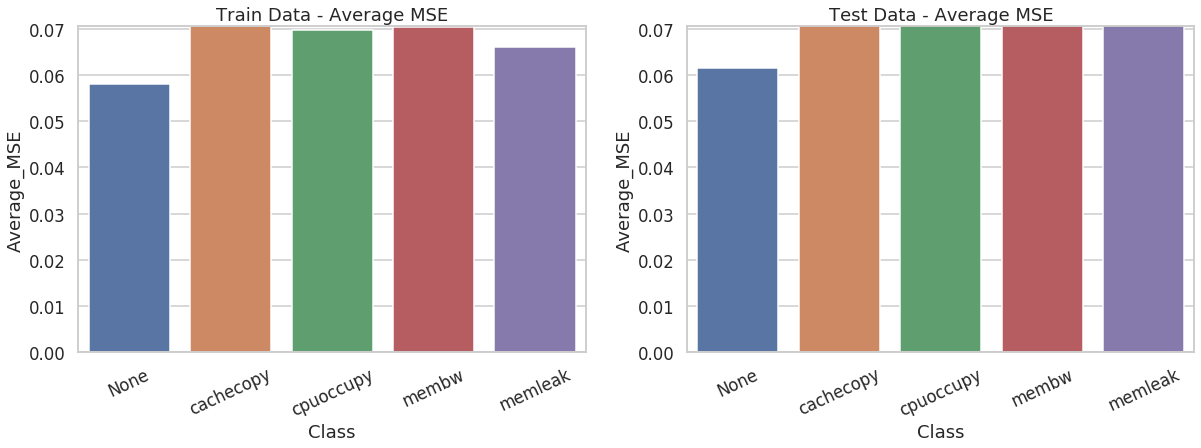

In [13]:
#Check overfitting

fig, axs = plt.subplots(1, 2)

mse_df = calc_MSE_class(autoencoder,train_data.values,train_label['anom'].values,ANOM_DICT)
sns.barplot(x="Class",y="Average_MSE",data=mse_df,ax=axs[0])
axs[0].set_title("Train Data - Average MSE")
axs[0].tick_params(axis='x', labelrotation= 25)
limit = max(mse_df['Average_MSE'])
axs[0].set_ylim(0,limit)
print(mse_df)


mse_df = calc_MSE_class(autoencoder,test_data.values,test_label['anom'].values,ANOM_DICT)
sns.barplot(x="Class",y="Average_MSE",data=mse_df,ax=axs[1])
axs[1].set_title("Test Data - Average MSE")
axs[1].tick_params(axis='x', labelrotation= 25)
axs[1].set_ylim(0,limit)
print(mse_df)